### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
if platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
    sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pingouin as pg
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.core.position import Position
from neuropy.plotting import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten

import subjects

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

## Define useful functions

In [2]:
def pf_corr_maze_remaze(row, nbins_each_sesh=50):
    """Calculate PF correlation for each row/neuron. 
    
    row: a DataFrame row of values (or 1d ndarray) where the first nbins_each_sesh bins 
    are firing rates for MAZE in each bin and the next nbins_each_sesh are for reMAZE"""
    maze_tc = row.values[0:nbins_each_sesh]
    remaze_tc = row.values[nbins_each_sesh:]
    

    return np.corrcoef([maze_tc, remaze_tc])[0, 1]

In [3]:
def get_pf_loc(row, nbins_each_sesh=50, end_prop=0.125):
    """Calculate placefield peak location
    
    row: a DataFrame row of values (or 1d ndarray) where the first nbins_each_sesh bins 
    are firing rates for MAZE in each bin and the next nbins_each_sesh are for reMAZE
    
    end_prop: propotion of the track corresponding to end - fields with locations less than end_prop or 
    more than 1 - end_prop are classified as 'end' pfs while the rest are classified as 'middle' pfs"""

    # Get location on track
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)
    
    if (imax < (nbins_each_sesh * end_prop)) | (imax > (nbins_each_sesh - nbins_each_sesh * end_prop)):
        loc = "end"
    else:
        loc = "middle"

    return loc

In [4]:
def pf_corr_maze_remaze_ends(row, nbins_each_sesh=50, end_prop=0.125):
    """Calculate PF correlation for each row/neuron but only consider neurons with peaks in at the end of the tracks,
    within `end_prop` of the end of the track"""

    # Calculate correlations
    pf_corr_row = pf_corr_maze_remaze(row, nbins_each_sesh=nbins_each_sesh)

    # Get location on track
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)

    if (imax < (nbins_each_sesh * end_prop)) | (imax > (nbins_each_sesh - nbins_each_sesh * end_prop)):
        return pf_corr_row
    else:
        return np.nan


In [5]:
def pf_corr_maze_remaze_middle(row, nbins_each_sesh=50, end_prop=0.125):
    """Calculate PF correlation for each row/neuron but only consider neurons with peaks in at the end of the tracks,
    within `end_prop` of the end of the track"""

    # Calculate correlations
    pf_corr_row = pf_corr_maze_remaze(row, nbins_each_sesh=nbins_each_sesh)

    # Get location on track
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)

    if (imax > (nbins_each_sesh * end_prop)) & (imax < (nbins_each_sesh - nbins_each_sesh * end_prop)):
        return pf_corr_row
    else:
        return np.nan


In [6]:
def get_imax(row):
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)

    return imax

In [7]:
def delta_rate_index(row, nbins_each_sesh=50, use_same_peak_bin=False):
    """Calculate change in max firing rate from MAZE to REMAZE for each row/neuron"""
    maze_tc = row.values[0:nbins_each_sesh]
    remaze_tc = row.values[nbins_each_sesh:]
    
    maze_max = np.nanmax(maze_tc)
    remaze_max = np.nanmax(remaze_tc)
    if use_same_peak_bin:
        imax = np.argmax(maze_tc)
        remaze_max = remaze_tc[imax]
    
    return (maze_max - remaze_max) / (maze_max + remaze_max)

In [8]:
def delta_pf_peak(row, nbins_each_sesh=50):
    maze_tc = row.values[0:nbins_each_sesh]
    remaze_tc = row.values[nbins_each_sesh:]

    return np.argmax(maze_tc) - np.argmax(remaze_tc)

In [9]:
def get_number_of_fields(pf_peak_or_width_list):
    nfields = [cell_peaks.size if ~np.all(np.isnan(cell_peaks)) else 0 for cell_peaks in pf_peak_or_width_list]

    return nfields

### Load in sessions

In [9]:
#1st # = maze trials, 2nd # = remaze trial, 2 trials = 1 lap up/down
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
sessions = subjects.remaze_sess()

### Examine firing rates of interneurons in each session

In [10]:
def calc_rough_uniformity_metric(pf_in):
    metric = []
    for ratemap_spiketrains_pos in pf_in.ratemap_spiketrains_pos:
        res = sstats.ecdf(ratemap_spiketrains_pos/pf_in.coords.max())
        metric.append(np.abs(res.cdf.probabilities - res.cdf.quantiles).sum())

    return np.array(metric)
    
# calc_rough_uniformity_metric(pfmaze)

In [11]:
# Calculate interneuron firing rates
neuron_type = "all" # "stable" # 'all' or 'stable'
fr_df = []
for ids, sess in enumerate(sessions):
    assert neuron_type in ("all", "stable")
    neurons_use = sess.neurons if neuron_type == "all" else sess.neurons_stable
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    fr_df_maze = neurons_use.time_slice(*maze).to_dataframe()
    fr_df_maze["session_type"] = "MAZE"
    
    fr_df_remaze = neurons_use.time_slice(*remaze).to_dataframe()
    fr_df_remaze["session_type"] = "reMAZE"

    delta_fr = fr_df_maze["mean_frate"] - fr_df_remaze["mean_frate"]
    fr_df_maze["delta_frate_maze_remaze"] = delta_fr
    fr_df_remaze["delta_frate_maze_remaze"] = np.nan
    
    fr_df_temp = pd.concat((fr_df_maze, fr_df_remaze), axis=0)
    fr_df_temp['neuron_id'] = fr_df_temp.index
    
    fr_df_temp["grp"] = sess.tag
    fr_df_temp["session"] = ids

    fr_df.append(fr_df_temp)
    
fr_df = pd.concat(fr_df, axis=0, ignore_index=True)
fr_df

Number of neurons: 146
Number of neurons: 146
Number of neurons: 288
Number of neurons: 288
Number of neurons: 206
Number of neurons: 206
Number of neurons: 170
Number of neurons: 170
Number of neurons: 144
Number of neurons: 144
Number of neurons: 171
Number of neurons: 171
Number of neurons: 242
Number of neurons: 242
Number of neurons: 106
Number of neurons: 106
Number of neurons: 61
Number of neurons: 61


,neuron_type,neuron_id,nspikes,mean_frate,session_type,delta_frate_maze_remaze,grp,session
0,pyr,0,777,0.211659,MAZE,0.125499,NSD,0
1,pyr,1,1994,0.543176,MAZE,-0.005908,NSD,0
2,mua,2,11173,3.043585,MAZE,0.579460,NSD,0
3,inter,3,29464,8.026151,MAZE,7.236598,NSD,0
4,pyr,4,180,0.049033,MAZE,-0.058142,NSD,0
...,...,...,...,...,...,...,...,...
3063,pyr,56,18,0.004632,reMAZE,NaN,SD,8
3064,pyr,57,61,0.015697,reMAZE,NaN,SD,8
3065,pyr,58,0,0.000000,reMAZE,NaN,SD,8
3066,pyr,59,98,0.025219,reMAZE,NaN,SD,8


In [12]:
# Use to look at t-tests for each session - not that meaningful due to generally low n for most sessions with interneurons
fr_use = fr_df[fr_df.neuron_type == "inter"]
for sid in fr_use.session.unique():
    print(pg.ttest(fr_use[(fr_use.session == sid) & (fr_use.session_type == "MAZE")]["mean_frate"],
         fr_use[(fr_use.session == sid) & (fr_use.session_type == "reMAZE")]["mean_frate"],
         paired=True))

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.775261    8   two-sided  0.460485  [-3.85, 7.76]  0.151978  0.412   

           power  
T-test  0.068889  
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.112094   13   two-sided  0.912461  [-6.15, 5.54]  0.018201  0.271   

           power  
T-test  0.050458  
               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test  1.118616    5   two-sided  0.314147  [-6.23, 15.83]  0.422187  0.595   

           power  
T-test  0.135612  
               T  dof alternative   p-val          CI95%   cohen-d   BF10  \
T-test  0.000131    5   two-sided  0.9999  [-4.64, 4.64]  0.000024  0.373   

        power  
T-test   0.05  
               T  dof alternative     p-val          CI95%  cohen-d   BF10  \
T-test  2.653792    8   two-sided  0.029084  [0.84, 11.97]  0.50306  2.757   

           power  
T-test  0.265359  
               T  dof alt

In [13]:
fr_use = fr_df[fr_df.neuron_type == "inter"]

# Significant drop of inhibition for SD group but not NSD group with paired t-test (for stable neurons only, doesn't hold if we include all)

print(pg.ttest(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
         fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"],
         paired=True))

# sstats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
#                 fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"])

# Distribution of interneuron firing rates is different between groups as well (stable neurons only, doesn't hold if we include all)
stats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"],
                fr_use[(fr_use.grp == "NSD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"])

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.897457   50   two-sided  0.373777  [-2.61, 6.84]  0.134034  0.223   

           power  
T-test  0.155484  


KstestResult(statistic=0.27563025210084036, pvalue=0.06784531209944468, statistic_location=1.7371729505088602, statistic_sign=-1)

In [14]:
fr_df["unique_nid"] = fr_df.apply(lambda row: int(f"{row.session}0{row.neuron_id}"), axis=1)

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_10861/4170912431.py:4: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.lineplot(data=fr_df[(fr_df.neuron_type == ntype) & (fr_df.grp == gname)], x="session_type", y="mean_frate",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_10861/4170912431.py:6: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.stripplot(data=fr_df[(fr_df.neuron_type == ntype) & (fr_df.grp == gname)], x="session_type", y="mean_frate",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_10861/4170912431.py:4: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.lineplot(data=fr_df[(fr_df.neuron_type == ntype) & (fr_df.grp == gname)], x="session_type", y="mean_frate",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_10861/4170912431.py:6: UserWarning: The palette list has more values

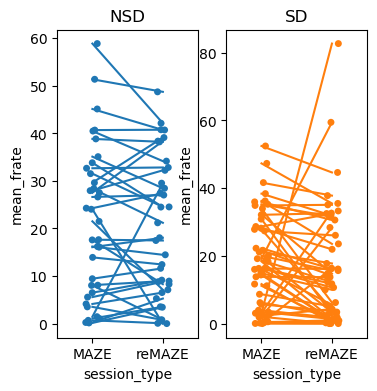

In [21]:
_, ax = plt.subplots(1, 2, figsize=(4, 4))
for idg, (gname, a) in enumerate(zip(["NSD", "SD"], ax)):
    pal_use = sns.color_palette()[idg:]
    sns.lineplot(data=fr_df[(fr_df.neuron_type == ntype) & (fr_df.grp == gname)], x="session_type", y="mean_frate",
                 hue="grp", units="unique_nid", estimator=None, legend=False, palette=pal_use, ax=a)
    sns.stripplot(data=fr_df[(fr_df.neuron_type == ntype) & (fr_df.grp == gname)], x="session_type", y="mean_frate", 
                  hue="grp", dodge=True, jitter=True, legend=False, palette=pal_use, ax=a)
    a.set_title(gname)

<Axes: xlabel='delta_frate_maze_remaze', ylabel='Proportion'>

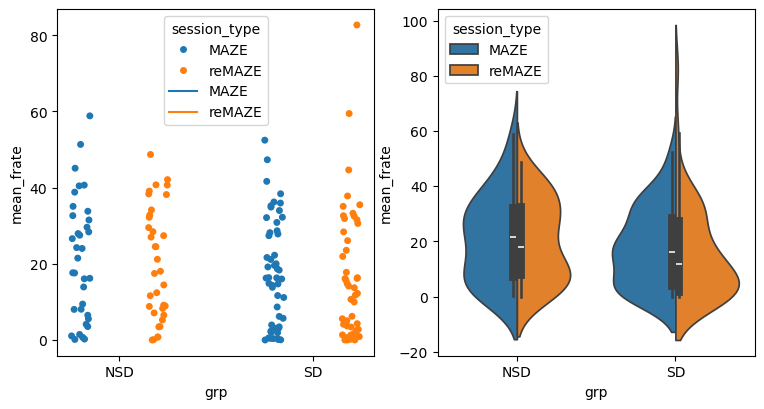

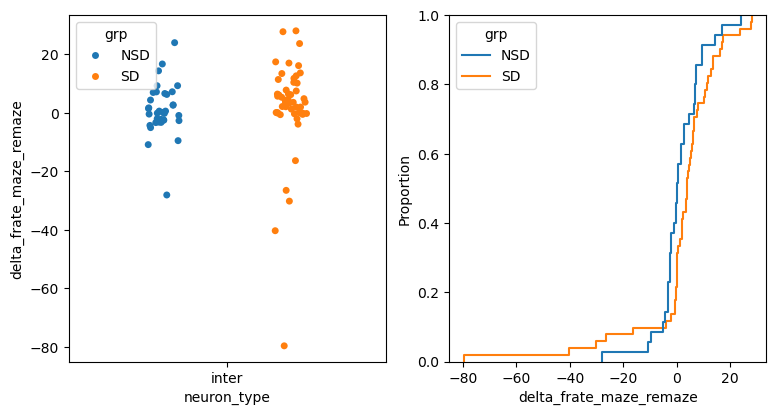

In [20]:
_, ax = plt.subplots(1, 2, figsize=(9, 4.5))
ntype = "inter"
sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", dodge=True, ax=ax[0])
sns.lineplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", units="unique_nid", estimator=None, ax=ax[0])
sns.violinplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", split=True, ax=ax[1])

_, ax2 = plt.subplots(1, 2, figsize=(9, 4.5))
# sns.violinplot(data=fr_df[fr_df.neuron_type == ntype], x="neuron_type", y="delta_frate_maze_remaze", hue="grp", split=True, ax=ax2[0])
sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], x="neuron_type", y="delta_frate_maze_remaze", hue="grp", dodge=True, ax=ax2[0])
sns.ecdfplot(data=fr_df[fr_df.neuron_type == ntype], x="delta_frate_maze_remaze", hue="grp", ax=ax2[1])